In [145]:
import librosa
import matplotlib
import scipy 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from scipy.signal import lfilter

import soundfile as sf

import phast
import abt

from matlab import MatlabData
from utils import create_neurogram, bin_over_y
from plotting import plot_pulse_train_stats

72.30264
(80, 243)
0.8912068965517241


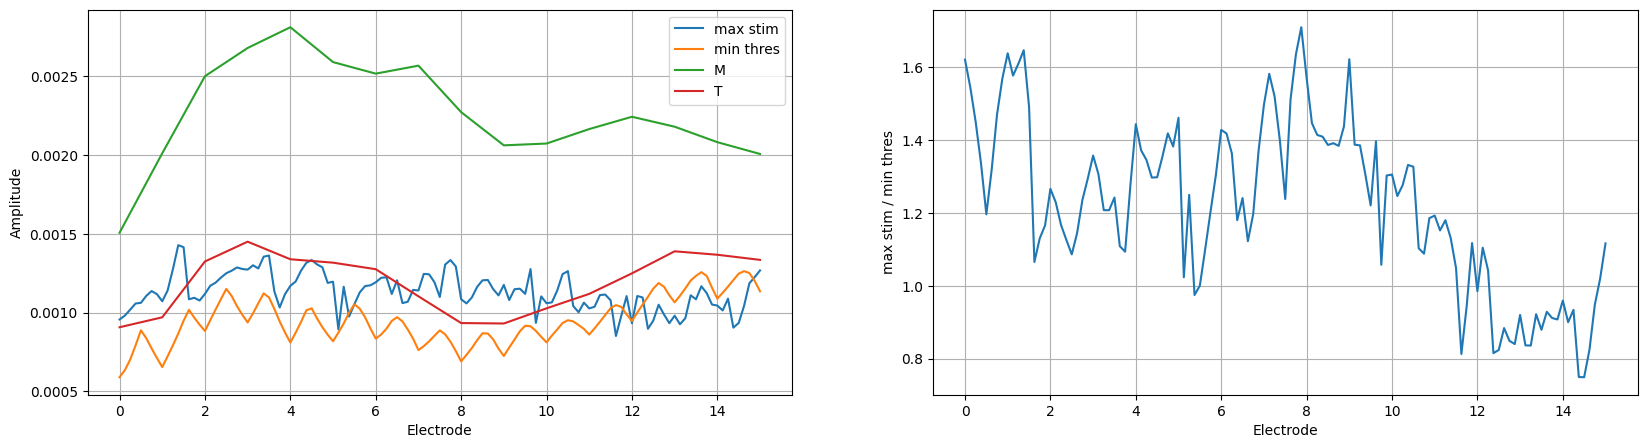

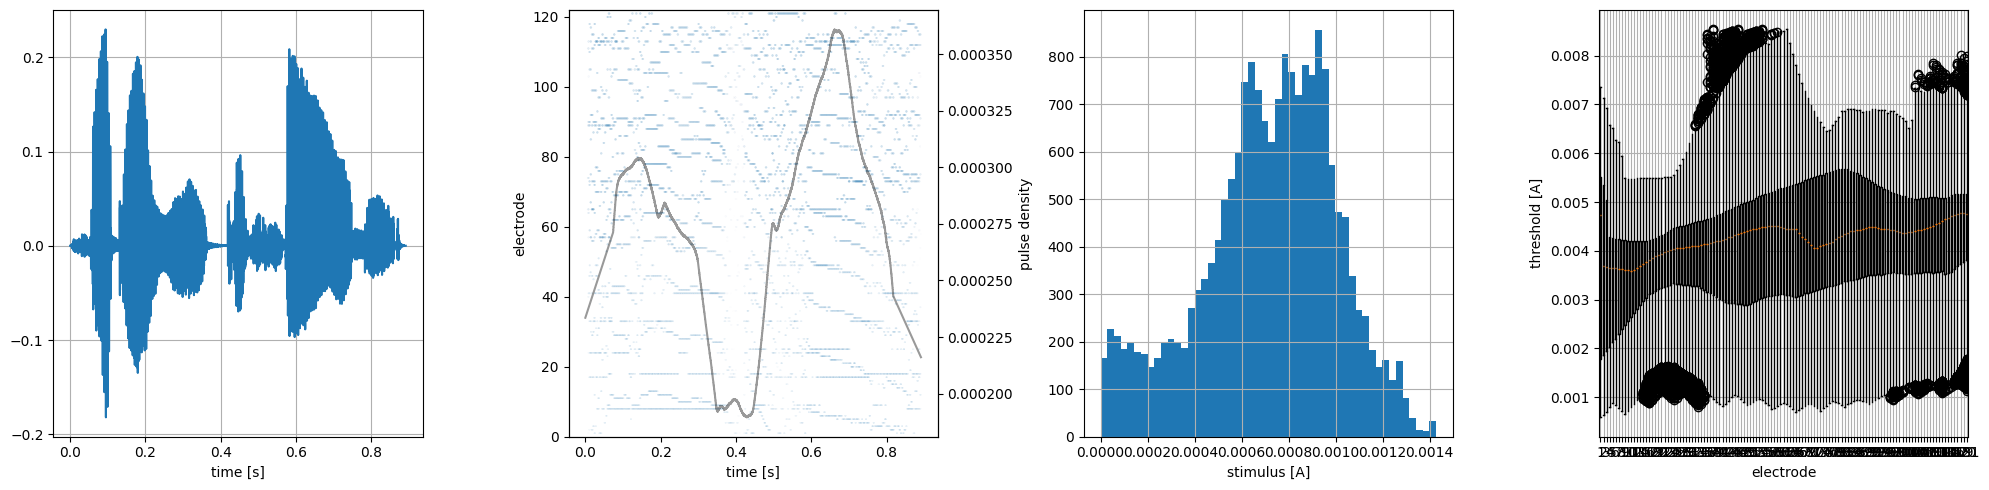

In [146]:
MIN_FREQ = 350
MAX_FREQ = 5000

FS = 17400
NAME = "defineit"
N_MELS = 80
N_FFT = 2048
N_HOP = N_FFT // 32
CS = True



MEL_SCALE = librosa.filters.mel_frequencies(N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ) 
MAT = MatlabData.read()

IDET = MAT.I_det[:, 4::8] if not CS else MAT.I_det
scaling_factor = 0.8

scaling_factor_no_m_t = 2.6

freq_f = scipy.interpolate.interp1d(
    np.r_[0, np.argmin(MAT.I_det[:,::8], axis=0), 3200], 
    np.r_[0, abt.utils.virtual_channel_frequencies(16, MAX_FREQ - 500), MAX_FREQ], 
    fill_value='extrapolate'
)

fidx = np.arange(0, 3200)
int_freq = freq_f(fidx)

pulse_train, audio_signal = abt.wav_to_electrodogram(
    abt.sounds[NAME], 
    current_steering=CS, 
    charge_balanced=False,  
    virtual_channels=True,
    apply_audiomixer=False,
    ramp_type = 'c',
    # M=MAT.M * 1e6 / scaling_factor,
    # T=MAT.T * 1e6 / scaling_factor,
    Fs = FS,
    stim_db = 65.0,
    ramp_duration=0.01
)
pulse_train *= scaling_factor_no_m_t

audio_signal = audio_signal[0]
duration = len(audio_signal) * (1 / FS)

cycle = 2 * 15
cycle_time = cycle * 18e-6
n_channels = pulse_train.shape[0]

S = librosa.feature.melspectrogram(y=audio_signal, sr=FS, n_fft=N_FFT, hop_length=N_HOP, n_mels=N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ)
ref_db = np.max(S)
print(ref_db)
print(S.shape)
print(duration)

plot_pulse_train_stats(pulse_train, audio_signal, MAT, IDET, FS) 

In [163]:
stimulus = phast.PulseTrain(pulse_train, time_step=MAT.pw)

decay = phast.LeakyIntegratorDecay(
    accommodation_amplitude=0.072,
    adaptation_amplitude=7.142,
    accommodation_rate=0.014,
    adaptation_rate=19.996
)

selected_fibers = np.arange(3200)

fibers = []
for fiber_idx in selected_fibers:
    fibers.append(
        phast.Fiber(
            i_det=IDET[fiber_idx],
            spatial_constant=MAT.spatial_factor(fiber_idx, IDET) * .1,
            sigma=MAT.sigma(fiber_idx, IDET),  
            fiber_id=fiber_idx,
            n_max=stimulus.n_pulses,  
            decay=decay,  
            store_stats=False,
        )
    )
    

fiber_stats = phast.phast(fibers, stimulus, generate_trials = 5, evaluate_in_parallel=True)

In [173]:
N_CYCLES = 2
BINSIZE = N_CYCLES * cycle_time

neurogram = create_neurogram(fiber_stats, selected_fibers, BINSIZE, duration)

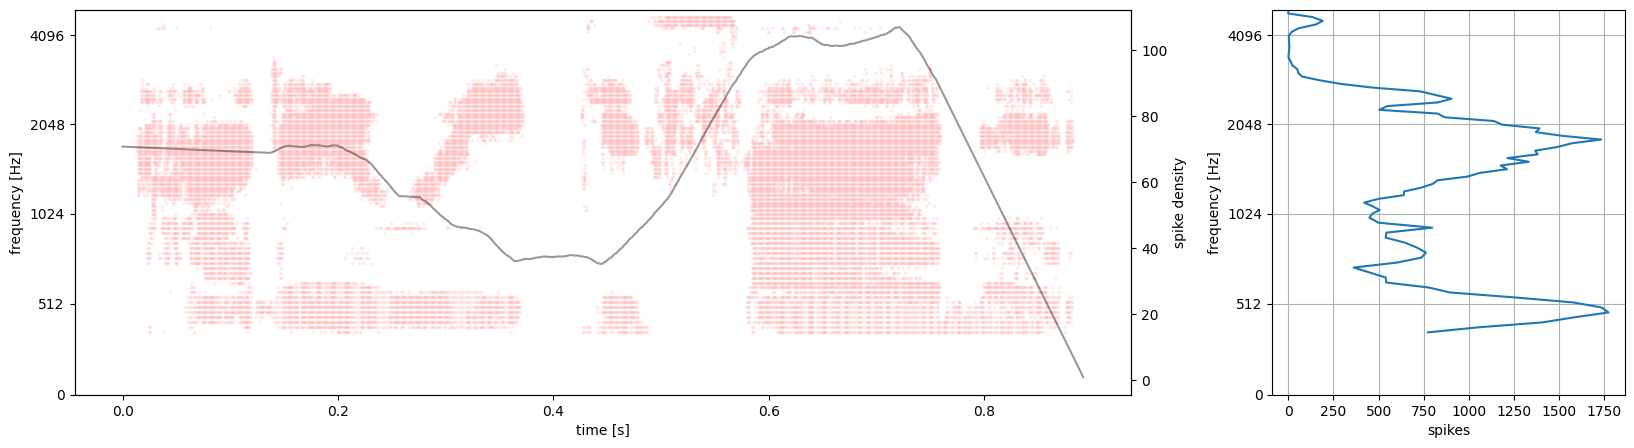

In [174]:
neurogram_freq_bin = bin_over_y(neurogram, int_freq, MEL_SCALE)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), width_ratios=[3, 1])
for i in range(N_MELS):
    x = np.where(neurogram_freq_bin[i])[0]
    ax1.scatter(x * BINSIZE, MEL_SCALE[i] * np.ones(len(x)), color="red", alpha=.05, s=3)
    
density = scipy.signal.savgol_filter(neurogram_freq_bin.sum(axis=0), 512 // N_CYCLES, 1).clip(0)
ax3 = ax1.twinx()
ax3.plot(np.arange(len(density)) * BINSIZE, density, alpha=.4, color="black", zorder=-1)
ax3.set_ylabel("spike density")
      
ax2.plot(neurogram_freq_bin.sum(axis=1), MEL_SCALE)
ax2.grid()
ax2.set_xlabel("spikes")
abt.utils.frequency_ax(ax2)
abt.utils.time_vs_freq(ax1)
ax2.set_ylim(0, MAX_FREQ)
ax1.set_ylim(0, MAX_FREQ);     


(80, 243)

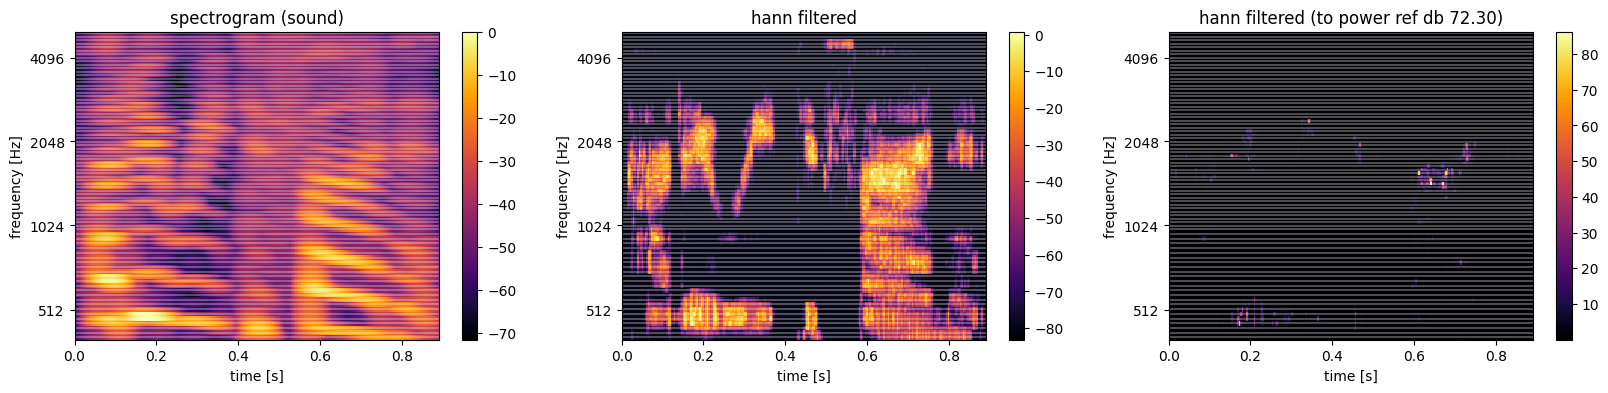

In [179]:
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 4))

S_db = librosa.power_to_db(S, ref=np.max)
ts = np.linspace(0, duration, len(S_db[0]))

abt.utils.plot_heatmap(ts, MEL_SCALE, S_db, ax0, f)
ax0.set_title("spectrogram (sound)")

filtered_data = abt.utils.apply_filter(neurogram_freq_bin, window_size=8, resample_to=S.shape[1])

t = np.linspace(0, duration, len(filtered_data[0]))
abt.utils.plot_heatmap(t, MEL_SCALE, filtered_data, ax=ax1, fig=f)
ax1.set_title("hann filtered")

ref_db = np.max(S)
mel_spec_ng = librosa.db_to_power(filtered_data, ref=ref_db)
abt.utils.plot_heatmap(t, MEL_SCALE, mel_spec_ng, ax=ax2, fig=f)
ax2.set_title(f"hann filtered (to power ref db {ref_db:.2f})");
filtered_data.shape


In [180]:
mel_inversed = librosa.feature.inverse.mel_to_audio(mel_spec_ng,  n_fft=N_FFT, hop_length=N_HOP, sr=FS, fmin=MIN_FREQ, fmax=MAX_FREQ)

mel_inversed = scipy.signal.resample(mel_inversed, audio_signal.size)

sc = (audio_signal.max() - audio_signal.min()) / (mel_inversed.max() - mel_inversed.min())
# mel_inversed = mel_inversed.clip(audio_signal.min(), audio_signal.max())
# mel_inversed *= sc

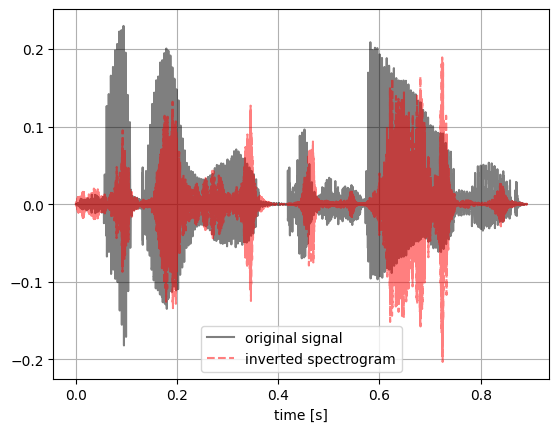

In [181]:
t_audio = np.arange(len(audio_signal)) * 1 / FS
plt.plot(t_audio, audio_signal, label="original signal", color="black", alpha=.5)
plt.xlabel("time [s]")

t_mel = np.arange(len(mel_inversed)) * 1 / FS

plt.plot(
    t_mel, 
    mel_inversed,
    label="inverted spectrogram", 
    color ="red", 
    linestyle="dashed", 
    alpha=.5
)

mel_filt = scipy.signal.savgol_filter(mel_inversed, 16, 2) 
# mel_filt *= (audio_signal.max() - audio_signal.min()) / (mel_filt.max() - mel_filt.min())

# plt.plot(
#     t_mel, mel_filt,
#     label="inverted spectrogram (filtered)", color ="blue", linestyle="dashed", alpha=.5
# ) 
plt.grid()
plt.legend()

sf.write(
    f"output/{NAME}.wav", audio_signal, FS, subtype='PCM_24'
)

# sf.write(
#     f"output/reconstructed_{NAME}_filt.wav", mel_filt, FS, subtype='PCM_24'
# )

sf.write(
    f"output/reconstructed_{NAME}_ci.wav", mel_inversed, FS, subtype='PCM_24'
)


# n = int(np.ceil(mel_inversed.size * (16000 / FS)))
# mp3 = scipy.signal.resample(mel_inversed, n)
# sf.write(
#         f"output/reconstructed_{NAME}_ci.mp3", mp3, 16000,
#         format='MP3', subtype='MPEG_LAYER_III'
# )


